<a href="https://colab.research.google.com/github/AKUSAbeysinghe/preschool_handwriting_cnn_t4gpu/blob/main/preschool_handwriting_cnn_t4gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install tensorflow_datasets
!pip install tensorflow_datasets

# Import libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np

# Verify T4 GPU
print("GPU devices:", tf.config.list_physical_devices('GPU'))  # Should show T4 GPU
print("TensorFlow version:", tf.__version__)

GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.19.0


In [ ]:
# Load EMNIST 'byclass' dataset (0-9, A-Z, a-z)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Preprocess function: Normalize and confirm shape
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    image = tf.ensure_shape(image, [28, 28, 1])  # Confirm EMNIST shape (28, 28, 1)
    return image, label

# Batch sizes and steps for T4 GPU
BATCH_SIZE = 64  # Optimal for T4 GPU
TRAIN_SAMPLES = 697932  # EMNIST train size
TEST_SAMPLES = 116323   # EMNIST test size
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE + 1  # ~10898
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~1818

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache().shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Verify shapes
for image, label in ds_train.take(1):
    print("Batch image shape:", image.shape)  # Should be (64, 28, 28, 1)
    print("Label shape:", label.shape)  # Should be (64,)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.HRBSDJ_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.HRBSDJ_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
Batch image shape: (64, 28, 28, 1)
Label shape: (64,)


In [ ]:
NUM_CLASSES = 62  # 0-9, A-Z, a-z
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), activation='relu'),  # Added for capacity
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu'),  # Extra layer for accuracy
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile with tuned learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Smaller for better convergence
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 0, 0, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 0, 0, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 0, 0, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 322,590 (1.23 MB)

 Trainable params: 320,670 (1.22 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Define augmentation layers
augmentation = models.Sequential([
    layers.RandomRotation(0.25),   # Strong rotation for variability
    layers.RandomTranslation(0.25, 0.25),  # Strong shift
    layers.RandomZoom(0.25)       # Strong zoom
])

# Apply augmentation
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])  # Confirm batch shape
    image = augmentation(image, training=True)
    return image, label

# Apply to training dataset
ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Verify augmented shape
for image, label in ds_train_aug.take(1):
    print("Augmented batch shape:", image.shape)  # (64, 28, 28, 1)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # Increased to reach ~40-50 epochs
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)
# Optional: Learning rate scheduler for further accuracy boost
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    return lr * tf.math.exp(-0.1)
lr_scheduler = callbacks.LearningRateScheduler(scheduler)

# Train
history = model.fit(
    ds_train_aug,
    epochs=50,
    validation_data=ds_test,
    callbacks=[early_stopping, reduce_lr, lr_scheduler],
    steps_per_epoch=STEPS_PER_EPOCH,  # ~10898
    validation_steps=VALIDATION_STEPS,  # ~1818
    verbose=1
)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Augmented batch shape: (64, 28, 28, 1)
Epoch 1/50


ValueError: Exception encountered when calling Conv2D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_1/conv2d_5_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_1/batch_normalization_4_1/batchnorm/add_1, sequential_1/conv2d_5_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,128], [3,3,128,128].[0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 128), dtype=float32)

In [ ]:
from tensorflow.keras import layers, models

NUM_CLASSES = 62  # 0-9, A-Z, a-z
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),  # Fixed: padding='same'
    layers.BatchNormalization(),
    layers.Conv2D(128, (2,2), activation='relu', padding='same'),  # Fixed: 2x2 kernel for small input
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 128)      │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,451,934 (13.17 MB)

 Trainable params: 3,450,014 (13.16 MB)

 Non-trainable params: 1,920 (7.50 KB)

Augmented batch shape: (64, 28, 28, 1)
Epoch 1/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 184s 16ms/step - accuracy: 0.4905 - loss: 1.9884 - val_accuracy: 0.7657 - val_loss: 0.7172 - learning_rate: 5.0000e-04
Epoch 2/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 123s 11ms/step - accuracy: 0.7167 - loss: 0.9000 - val_accuracy: 0.7942 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 124s 11ms/step - accuracy: 0.7425 - loss: 0.8033 - val_accuracy: 0.7891 - val_loss: 0.6259 - learning_rate: 5.0000e-04
Epoch 4/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 124s 11ms/step - accuracy: 0.7564 - loss: 0.7527 - val_accuracy: 0.8073 - val_loss: 0.5665 - learning_rate: 5.0000e-04
Epoch 5/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 124s 11ms/step - accuracy: 0.7640 - loss: 0.7235 - val_accuracy: 0.8057 - val_loss: 0.5564 - learning_rate: 5.0000e-04
Epoch 6/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 123s 11ms/step - accuracy: 0.7699 - loss: 0.7039 - val_accuracy: 0.7995 - val_loss: 0.5896 - learning_

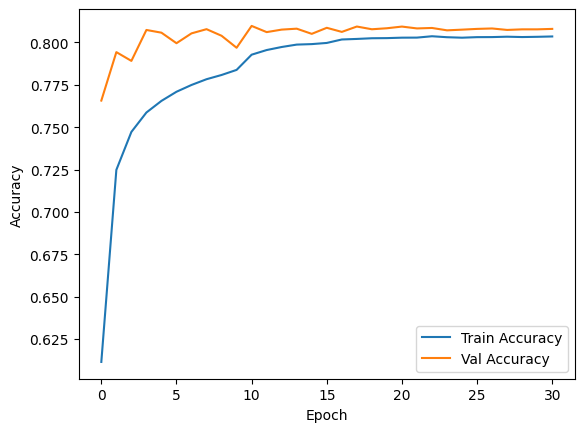

In [ ]:
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# Define augmentation layers
augmentation = models.Sequential([
    layers.RandomRotation(0.25),   # Strong rotation for variability
    layers.RandomTranslation(0.25, 0.25),  # Strong shift
    layers.RandomZoom(0.25)       # Strong zoom
])

# Apply augmentation
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

# Apply to training dataset
ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Verify augmented shape
for image, label in ds_train_aug.take(1):
    print("Augmented batch shape:", image.shape)  # (64, 28, 28, 1)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # Increased to reach ~40-50 epochs
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Train
history = model.fit(
    ds_train_aug,
    epochs=50,
    validation_data=ds_test,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=STEPS_PER_EPOCH,  # ~10898
    validation_steps=VALIDATION_STEPS,  # ~1818
    verbose=1
)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# After training
model.save('/content/preschool_handwriting_cnn_t4gpu.h5')
print("Model saved to /content/preschool_handwriting_cnn_t4gpu.h5")

# Verify file exists
!ls -lh /content/preschool_handwriting_cnn_t4gpu.h5

# Optional: Copy to Google Drive
from google.colab import drive
drive.mount('/content/drive')
!cp /content/preschool_handwriting_cnn_t4gpu.h5 /content/drive/MyDrive/preschool_handwriting_cnn_t4gpu.h5

Model saved to /content/preschool_handwriting_cnn_t4gpu.h5
-rw-r--r-- 1 root root 40M Sep 28 12:48 /content/preschool_handwriting_cnn_t4gpu.h5
Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('preschool_handwriting_cnn_t4gpu.h5')
print("Model loaded successfully")

Model loaded successfully


In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Authenticate and mount Drive
# Copy to Google Drive (replace 'MyDrive/models/' with your desired path)
!cp /content/preschool_handwriting_cnn_t4gpu.h5 /content/drive/MyDrive/models/preschool_handwriting_cnn_t4gpu.h5
print("Model copied to Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot create regular file '/content/drive/MyDrive/models/preschool_handwriting_cnn_t4gpu.h5': No such file or directory
Model copied to Google Drive


In [ ]:
from google.colab import files
files.download('/content/preschool_handwriting_cnn_t4gpu.h5')  # Or use 'preschool_handwriting_cnn_t4gpu_updated.h5'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')  # Expect ~85-88%

Test accuracy: 0.8097


In [ ]:
!ls -lh /content/preschool_handwriting_cnn_t4gpu.h5 || echo "Model file not found in /content/"

-rw-r--r-- 1 root root 40M Sep 28 12:48 /content/preschool_handwriting_cnn_t4gpu.h5


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the saved model
model_path = '/content/preschool_handwriting_cnn_t4gpu.h5'
try:
    model = load_model(model_path)
    print("Model loaded successfully from /content/")
except FileNotFoundError:
    print(f"Error: '{model_path}' not found in /content/. Uploading file...")
    from google.colab import files
    uploaded = files.upload()
    model = load_model(model_path)
    print("Model loaded successfully after upload")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define stronger augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.3),  # Increased for better generalization
    layers.RandomTranslation(0.3, 0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2)  # Added for robustness
])

# Apply augmentation (unchanged)
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

# Apply to training dataset
try:
    ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    for image, label in ds_train_aug.take(1):
        print("Augmented batch shape:", image.shape)  # (64, 28, 28, 1)
except NameError:
    print("Error: ds_train not defined. Please define the dataset (see prerequisite code).")
    raise

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,  # Allow ~40-50 epochs
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.05)
lr_scheduler = callbacks.LearningRateScheduler(scheduler)

# Continue training
try:
    history = model.fit(
        ds_train_aug,
        epochs=50,  # Total (30 previous + 20 more)
        initial_epoch=30,  # Start from epoch 31
        validation_data=ds_test,
        callbacks=[early_stopping, reduce_lr, lr_scheduler],
        steps_per_epoch=STEPS_PER_EPOCH,  # ~10898
        validation_steps=VALIDATION_STEPS,  # ~1818
        verbose=1
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
except NameError:
    print("Error: ds_test, STEPS_PER_EPOCH, or VALIDATION_STEPS not defined. Please define them.")
    raise

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')  # Expect ~85-88%

# Save the updated model
updated_model_path = '/content/preschool_handwriting_cnn_t4gpu_updated.h5'
model.save(updated_model_path)
print(f"Updated model saved to {updated_model_path}")

# Verify saved file
!ls -lh {updated_model_path}

# Optional: Download the updated model
from google.colab import files
files.download(updated_model_path)

Model loaded successfully from /content/
Augmented batch shape: (64, 28, 28, 1)


ValueError: The output of the `schedule` function should be a float. Got: 9.512294491287321e-05

Model loaded successfully from /content/
Augmented batch shape: (64, 28, 28, 1)
Epoch 31/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 149s 13ms/step - accuracy: 0.7220 - loss: 0.8969 - val_accuracy: 0.8198 - val_loss: 0.5225 - learning_rate: 9.5123e-05
Epoch 32/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 132s 12ms/step - accuracy: 0.7328 - loss: 0.8447 - val_accuracy: 0.8184 - val_loss: 0.5264 - learning_rate: 9.0484e-05
Epoch 33/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 131s 12ms/step - accuracy: 0.7366 - loss: 0.8324 - val_accuracy: 0.8205 - val_loss: 0.5184 - learning_rate: 8.6071e-05
Epoch 34/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 131s 12ms/step - accuracy: 0.7380 - loss: 0.8238 - val_accuracy: 0.8204 - val_loss: 0.5192 - learning_rate: 8.1873e-05
Epoch 35/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 131s 12ms/step - accuracy: 0.7406 - loss: 0.8157 - val_accuracy: 0.8213 - val_loss: 0.5125 - learning_rate: 7.7880e-05
Epoch 36/50
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 131s 12ms/step - accuracy: 0.7408 - loss: 0.8126 - val_

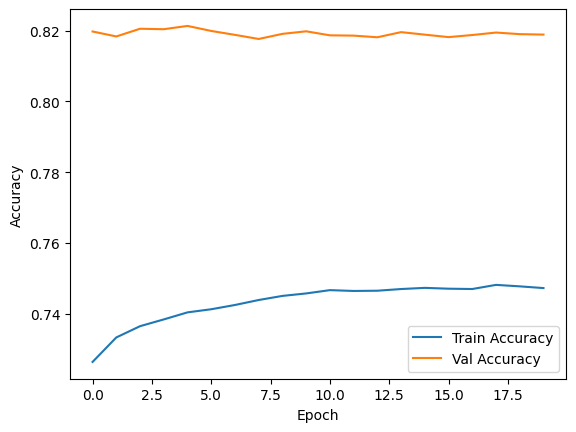

Test accuracy: 0.8213
Updated model saved to /content/preschool_handwriting_cnn_t4gpu_updated.h5
-rw-r--r-- 1 root root 40M Sep 28 14:50 /content/preschool_handwriting_cnn_t4gpu_updated.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the saved model
model_path = '/content/preschool_handwriting_cnn_t4gpu.h5'
try:
    model = load_model(model_path)
    print("Model loaded successfully from /content/")
except FileNotFoundError:
    print(f"Error: '{model_path}' not found in /content/. Uploading file...")
    from google.colab import files
    uploaded = files.upload()
    model = load_model(model_path)
    print("Model loaded successfully after upload")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define stronger augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.3, 0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2)
])

# Apply augmentation (unchanged)
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

# Apply to training dataset
try:
    ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    for image, label in ds_train_aug.take(1):
        print("Augmented batch shape:", image.shape)  # (64, 28, 28, 1)
except NameError:
    print("Error: ds_train not defined. Please define the dataset (see prerequisite code).")
    raise

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,  # Allow ~40-50 epochs
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return float(lr * tf.math.exp(-0.05))  # Convert to float
lr_scheduler = callbacks.LearningRateScheduler(scheduler)

# Continue training
try:
    history = model.fit(
        ds_train_aug,
        epochs=50,  # Total (30 previous + 20 more)
        initial_epoch=30,  # Start from epoch 31
        validation_data=ds_test,
        callbacks=[early_stopping, reduce_lr, lr_scheduler],
        steps_per_epoch=STEPS_PER_EPOCH,  # ~10898
        validation_steps=VALIDATION_STEPS,  # ~1818
        verbose=1
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
except NameError:
    print("Error: ds_test, STEPS_PER_EPOCH, or VALIDATION_STEPS not defined. Please define them.")
    raise

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')  # Expect ~85-88%

# Save the updated model
updated_model_path = '/content/preschool_handwriting_cnn_t4gpu_updated.h5'
model.save(updated_model_path)
print(f"Updated model saved to {updated_model_path}")

# Verify saved file
!ls -lh {updated_model_path}

# Optional: Download the updated model
from google.colab import files
files.download(updated_model_path)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the saved model
model_path = '/content/preschool_handwriting_cnn_t4gpu.h5'
try:
    base_model = load_model(model_path)
    print("Model loaded successfully from /content/")
except FileNotFoundError:
    print(f"Error: '{model_path}' not found in /content/. Uploading file...")
    from google.colab import files
    uploaded = files.upload()
    base_model = load_model(model_path)
    print("Model loaded successfully after upload")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Create new model with additional Dense layer
new_model = models.Sequential()
for layer in base_model.layers[:-1]:  # Exclude final Dense(62)
    new_model.add(layer)
new_model.add(layers.Dense(256, activation='relu'))  # Add capacity
new_model.add(layers.BatchNormalization())
new_model.add(layers.Dropout(0.5))
new_model.add(layers.Dense(62, activation='softmax'))

# Compile with adjusted learning rate
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),  # Slightly lower
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define balanced augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.2),  # Reduced to prevent underfitting
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.15)
])

# Apply augmentation
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

# Apply to training dataset
try:
    ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    for image, label in ds_train_aug.take(1):
        print("Augmented batch shape:", image.shape)  # (64, 28, 28, 1)
except NameError:
    print("Error: ds_train not defined. Please define the dataset (see prerequisite code).")
    raise

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # Reduced to stop if no improvement
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # More gradual reduction
    patience=5,
    min_lr=1e-7
)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return float(lr * tf.math.exp(-0.02))  # Slower decay
lr_scheduler = callbacks.LearningRateScheduler(scheduler)

# Continue training
try:
    history = new_model.fit(
        ds_train_aug,
        epochs=100,  # Extend to allow more learning
        initial_epoch=50,  # Start from epoch 51
        validation_data=ds_test,
        callbacks=[early_stopping, reduce_lr, lr_scheduler],
        steps_per_epoch=STEPS_PER_EPOCH,  # ~10898
        validation_steps=VALIDATION_STEPS,  # ~1818
        verbose=1
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
except NameError:
    print("Error: ds_test, STEPS_PER_EPOCH, or VALIDATION_STEPS not defined. Please define them.")
    raise

# Evaluate on test set
test_loss, test_acc = new_model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')  # Expect ~85-88%

# Save the updated model
updated_model_path = '/content/preschool_handwriting_cnn_t4gpu_updated.h5'
new_model.save(updated_model_path)
print(f"Updated model saved to {updated_model_path}")

# Verify saved file
!ls -lh {updated_model_path}

# Download the updated model
from google.colab import files
files.download(updated_model_path)

Model loaded successfully from /content/
Augmented batch shape: (64, 28, 28, 1)
Epoch 51/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 156s 13ms/step - accuracy: 0.5883 - loss: 1.6940 - val_accuracy: 0.8341 - val_loss: 0.4940 - learning_rate: 4.9010e-05
Epoch 52/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 185s 12ms/step - accuracy: 0.7811 - loss: 0.6746 - val_accuracy: 0.8365 - val_loss: 0.4723 - learning_rate: 4.8039e-05
Epoch 53/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 132s 12ms/step - accuracy: 0.7973 - loss: 0.6156 - val_accuracy: 0.8385 - val_loss: 0.4609 - learning_rate: 4.7088e-05
Epoch 54/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 142s 12ms/step - accuracy: 0.8035 - loss: 0.5913 - val_accuracy: 0.8398 - val_loss: 0.4548 - learning_rate: 4.6156e-05
Epoch 55/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 133s 12ms/step - accuracy: 0.8079 - loss: 0.5742 - val_accuracy: 0.8399 - val_loss: 0.4536 - learning_rate: 4.5242e-05
Epoch 56/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 144s 12ms/step - accuracy: 0.8105 - loss: 0.5644 

In [ ]:
!ls -lh /content/preschool_handwriting_cnn_t4gpu_updated.h5 || echo "Updated model not found"
!ls -lh /content/preschool_handwriting_cnn_t4gpu.h5

ls: cannot access '/content/preschool_handwriting_cnn_t4gpu_updated.h5': No such file or directory
Updated model not found
ls: cannot access '/content/preschool_handwriting_cnn_t4gpu.h5': No such file or directory


In [ ]:
!ls -lh /content/preschool_handwriting_cnn_t4gpu_updated.h5 || echo "Updated model not found"
!ls -lh /content/preschool_handwriting_cnn_t4gpu.h5

ls: cannot access '/content/preschool_handwriting_cnn_t4gpu_updated.h5': No such file or directory
Updated model not found
ls: cannot access '/content/preschool_handwriting_cnn_t4gpu.h5': No such file or directory


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import tensorflow as tf

# Try to load the most recent model
updated_model_path = '/content/preschool_handwriting_cnn_t4gpu_updated.h5'
original_model_path = '/content/preschool_handwriting_cnn_t4gpu.h5'

try:
    model = load_model(updated_model_path)
    print("Loaded updated model from", updated_model_path)
    initial_epoch = 76  # Resume from epoch 77
except FileNotFoundError:
    print(f"Updated model not found at {updated_model_path}. Trying original model...")
    try:
        base_model = load_model(original_model_path)
        print("Loaded original model from", original_model_path)
        # Rebuild with Dense layer
        model = models.Sequential()
        for layer in base_model.layers[:-1]:  # Exclude Dense(62)
            model.add(layer)
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(62, activation='softmax'))
        initial_epoch = 50  # Resume from epoch 51
    except FileNotFoundError:
        print(f"Error: No model found. Please upload 'preschool_handwriting_cnn_t4gpu.h5' or 'preschool_handwriting_cnn_t4gpu_updated.h5'.")
        from google.colab import files
        uploaded = files.upload()
        model_file = list(uploaded.keys())[0]
        if model_file not in ['preschool_handwriting_cnn_t4gpu.h5', 'preschool_handwriting_cnn_t4gpu_updated.h5']:
            print(f"Error: Uploaded file '{model_file}' is incorrect. Please upload the correct model.")
            raise FileNotFoundError("Incorrect model file uploaded")
        base_model = load_model(model_file)
        print(f"Loaded model from uploaded file: {model_file}")
        # Rebuild with Dense layer
        model = models.Sequential()
        for layer in base_model.layers[:-1]:
            model.add(layer)
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(62, activation='softmax'))
        initial_epoch = 76 if 'updated' in model_file else 50
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.15)
])

# Apply augmentation
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

# Apply to training dataset
try:
    ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    for image, label in ds_train_aug.take(1):
        print("Augmented batch shape:", image.shape)  # (64, 28, 28, 1)
except NameError:
    print("Error: ds_train not defined. Please define the dataset (see prerequisite code).")
    raise

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return float(lr * tf.math.exp(-0.02))
lr_scheduler = callbacks.LearningRateScheduler(scheduler)
checkpoint = callbacks.ModelCheckpoint(
    updated_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Continue training
try:
    history = model.fit(
        ds_train_aug,
        epochs=100,
        initial_epoch=initial_epoch,  # 76 or 50
        validation_data=ds_test,
        callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint],
        steps_per_epoch=STEPS_PER_EPOCH,  # ~10898
        validation_steps=VALIDATION_STEPS,  # ~1818
        verbose=1
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
except NameError:
    print("Error: ds_test, STEPS_PER_EPOCH, or VALIDATION_STEPS not defined. Please define them.")
    raise

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')  # Expect ~85-88%

# Save the final model
final_model_path = '/content/preschool_handwriting_cnn_t4gpu_final.h5'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

# Verify saved files
!ls -lh {updated_model_path}
!ls -lh {final_model_path}

# Download the final model
from google.colab import files
files.download(final_model_path)

Updated model not found at /content/preschool_handwriting_cnn_t4gpu_updated.h5. Trying original model...
Error: No model found. Please upload 'preschool_handwriting_cnn_t4gpu.h5' or 'preschool_handwriting_cnn_t4gpu_updated.h5'.


Saving preschool_handwriting_cnn_t4gpu_updated.h5 to preschool_handwriting_cnn_t4gpu_updated.h5


Loaded model from uploaded file: preschool_handwriting_cnn_t4gpu_updated.h5
Error: ds_train not defined. Please define the dataset (see prerequisite code).


NameError: name 'ds_train' is not defined

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load EMNIST 'byclass' dataset
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

# Batch sizes and steps
BATCH_SIZE = 64
TRAIN_SAMPLES = 697932
TEST_SAMPLES = 116323
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE + 1  # ~10898
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~1818

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache().shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.S1AA2N_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.S1AA2N_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the uploaded model
updated_model_path = '/content/preschool_handwriting_cnn_t4gpu_updated.h5'
try:
    model = load_model(updated_model_path)
    print("Loaded updated model from", updated_model_path)
    initial_epoch = 76  # Resume from epoch 77
except FileNotFoundError:
    print(f"Error: '{updated_model_path}' not found. Please upload again.")
    from google.colab import files
    uploaded = files.upload()
    model_file = list(uploaded.keys())[0]
    if model_file != 'preschool_handwriting_cnn_t4gpu_updated.h5':
        print(f"Error: Uploaded file '{model_file}' is incorrect.")
        raise FileNotFoundError("Incorrect model file uploaded")
    model = load_model(updated_model_path)
    print("Loaded model from uploaded file:", updated_model_path)
    initial_epoch = 76
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.15)
])

# Apply augmentation
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

# Apply to training dataset
ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
for image, label in ds_train_aug.take(1):
    print("Augmented batch shape:", image.shape)  # (64, 28, 28, 1)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return float(lr * tf.math.exp(-0.02))
lr_scheduler = callbacks.LearningRateScheduler(scheduler)
checkpoint = callbacks.ModelCheckpoint(
    updated_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Continue training
history = model.fit(
    ds_train_aug,
    epochs=100,
    initial_epoch=initial_epoch,  # Start from epoch 77
    validation_data=ds_test,
    callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint],
    steps_per_epoch=STEPS_PER_EPOCH,  # ~10898
    validation_steps=VALIDATION_STEPS,  # ~1818
    verbose=1
)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')  # Expect ~85-88%

# Save the final model
final_model_path = '/content/preschool_handwriting_cnn_t4gpu_final.h5'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

# Verify saved files
!ls -lh {updated_model_path}
!ls -lh {final_model_path}

# Download the final model
from google.colab import files
files.download(final_model_path)

Loaded updated model from /content/preschool_handwriting_cnn_t4gpu_updated.h5
Augmented batch shape: (64, 28, 28, 1)
Epoch 77/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8155 - loss: 0.5409
Epoch 77: val_accuracy improved from -inf to 0.83597, saving model to /content/preschool_handwriting_cnn_t4gpu_updated.h5


10906/10906 ━━━━━━━━━━━━━━━━━━━━ 4706s 431ms/step - accuracy: 0.8155 - loss: 0.5409 - val_accuracy: 0.8360 - val_loss: 0.4604 - learning_rate: 4.9010e-05
Epoch 78/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8211 - loss: 0.5166
Epoch 78: val_accuracy improved from 0.83597 to 0.83687, saving model to /content/preschool_handwriting_cnn_t4gpu_updated.h5


10906/10906 ━━━━━━━━━━━━━━━━━━━━ 4656s 427ms/step - accuracy: 0.8211 - loss: 0.5166 - val_accuracy: 0.8369 - val_loss: 0.4557 - learning_rate: 4.8039e-05
Epoch 79/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8224 - loss: 0.5118
Epoch 79: val_accuracy improved from 0.83687 to 0.83981, saving model to /content/preschool_handwriting_cnn_t4gpu_updated.h5


10906/10906 ━━━━━━━━━━━━━━━━━━━━ 4663s 428ms/step - accuracy: 0.8224 - loss: 0.5118 - val_accuracy: 0.8398 - val_loss: 0.4438 - learning_rate: 4.7088e-05
Epoch 80/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8253 - loss: 0.5041
Epoch 80: val_accuracy improved from 0.83981 to 0.84107, saving model to /content/preschool_handwriting_cnn_t4gpu_updated.h5


10906/10906 ━━━━━━━━━━━━━━━━━━━━ 4663s 428ms/step - accuracy: 0.8253 - loss: 0.5041 - val_accuracy: 0.8411 - val_loss: 0.4408 - learning_rate: 4.6156e-05
Epoch 81/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8255 - loss: 0.5013
Epoch 81: val_accuracy did not improve from 0.84107
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 4661s 427ms/step - accuracy: 0.8255 - loss: 0.5013 - val_accuracy: 0.8400 - val_loss: 0.4427 - learning_rate: 4.5242e-05
Epoch 82/100
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8253 - loss: 0.5005
Epoch 82: val_accuracy improved from 0.84107 to 0.84184, saving model to /content/preschool_handwriting_cnn_t4gpu_updated.h5


10906/10906 ━━━━━━━━━━━━━━━━━━━━ 4715s 432ms/step - accuracy: 0.8253 - loss: 0.5005 - val_accuracy: 0.8418 - val_loss: 0.4370 - learning_rate: 4.4346e-05
Epoch 83/100
 1809/10906 ━━━━━━━━━━━━━━━━━━━━ 1:01:25 405ms/step - accuracy: 0.8277 - loss: 0.4988

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
from google.colab import files
import glob

# Load EMNIST 'byclass' test dataset
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train[:10%]', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True
)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

# Prepare test dataset
BATCH_SIZE = 8
TEST_SAMPLES = 116323  # EMNIST test set size
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~14541
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Upload model files
print("Upload your .keras model files (e.g., preschool_handwriting_cnn_t4gpu_final (2).keras):")
uploaded = files.upload()

# Get list of uploaded model files
model_files = list(uploaded.keys())
if not model_files:
    print("No model files uploaded. Please try again.")
else:
    print("Uploaded model files:", model_files)

# Evaluate each model
for model_file in model_files:
    try:
        # Load the model
        model = load_model(model_file)
        print(f"\nEvaluating model: {model_file}")

        # Evaluate on test dataset
        test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=1)
        print(f"Model: {model_file}")
        print(f"Test accuracy: {test_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}\n")

    except Exception as e:
        print(f"Error evaluating {model_file}: {e}\n")

# Optional: Check existing models in /content/
print("Existing model files in /content/:")
existing_models = glob.glob('/content/preschool_handwriting_cnn_t4gpu*.keras')
for f in existing_models:
    print(f)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.3QNRVO_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.3QNRVO_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
Upload your .keras model files (e.g., preschool_handwriting_cnn_t4gpu_final (2).keras):


Saving preschool_handwriting_cnn_t4gpu.h5 to preschool_handwriting_cnn_t4gpu.h5
Uploaded model files: ['preschool_handwriting_cnn_t4gpu.h5']



Evaluating model: preschool_handwriting_cnn_t4gpu.h5
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 298s 20ms/step - accuracy: 0.8090 - loss: 0.5488
Model: preschool_handwriting_cnn_t4gpu.h5
Test accuracy: 0.8097
Test loss: 0.5474

Existing model files in /content/:


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
from google.colab import files
import glob

# Load EMNIST 'byclass' test dataset
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train[:10%]', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True
)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

# Prepare test dataset
BATCH_SIZE = 8
TEST_SAMPLES = 116323  # EMNIST test set size
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~14541
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Upload model files
print("Upload your .keras model files (e.g., preschool_handwriting_cnn_t4gpu_final (2).keras):")
uploaded = files.upload()

# Get list of uploaded model files
model_files = list(uploaded.keys())
if not model_files:
    print("No model files uploaded. Please try again.")
else:
    print("Uploaded model files:", model_files)

# Evaluate each model
for model_file in model_files:
    try:
        # Load the model
        model = load_model(model_file)
        print(f"\nEvaluating model: {model_file}")

        # Evaluate on test dataset
        test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=1)
        print(f"Model: {model_file}")
        print(f"Test accuracy: {test_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}\n")

    except Exception as e:
        print(f"Error evaluating {model_file}: {e}\n")

# Optional: Check existing models in /content/
print("Existing model files in /content/:")
existing_models = glob.glob('/content/preschool_handwriting_cnn_t4gpu*.keras')
for f in existing_models:
    print(f)

Upload your .keras model files (e.g., preschool_handwriting_cnn_t4gpu_final (2).keras):


Saving preschool_handwriting_cnn_t4gpu_updated.h5 to preschool_handwriting_cnn_t4gpu_updated.h5
Uploaded model files: ['preschool_handwriting_cnn_t4gpu_updated.h5']



Evaluating model: preschool_handwriting_cnn_t4gpu_updated.h5
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 299s 21ms/step - accuracy: 0.8202 - loss: 0.5128
Model: preschool_handwriting_cnn_t4gpu_updated.h5
Test accuracy: 0.8213
Test loss: 0.5125

Existing model files in /content/:


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
from google.colab import files
import glob

# Load EMNIST 'byclass' test dataset
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train[:10%]', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True
)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

# Prepare test dataset
BATCH_SIZE = 8
TEST_SAMPLES = 116323  # EMNIST test set size
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~14541
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Upload model files
print("Upload your .keras model files (e.g., preschool_handwriting_cnn_t4gpu_final (2).keras):")
uploaded = files.upload()

# Get list of uploaded model files
model_files = list(uploaded.keys())
if not model_files:
    print("No model files uploaded. Please try again.")
else:
    print("Uploaded model files:", model_files)

# Evaluate each model
for model_file in model_files:
    try:
        # Load the model
        model = load_model(model_file)
        print(f"\nEvaluating model: {model_file}")

        # Evaluate on test dataset
        test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=1)
        print(f"Model: {model_file}")
        print(f"Test accuracy: {test_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}\n")

    except Exception as e:
        print(f"Error evaluating {model_file}: {e}\n")

# Optional: Check existing models in /content/
print("Existing model files in /content/:")
existing_models = glob.glob('/content/preschool_handwriting_cnn_t4gpu*.keras')
for f in existing_models:
    print(f)

Upload your .keras model files (e.g., preschool_handwriting_cnn_t4gpu_final (2).keras):


Saving preschool_handwriting_cnn_t4gpu_final (1).keras to preschool_handwriting_cnn_t4gpu_final (1).keras
Uploaded model files: ['preschool_handwriting_cnn_t4gpu_final (1).keras']


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 62 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluating model: preschool_handwriting_cnn_t4gpu_final (1).keras
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 340s 23ms/step - accuracy: 0.8588 - loss: 0.3880
Model: preschool_handwriting_cnn_t4gpu_final (1).keras
Test accuracy: 0.8596
Test loss: 0.3879

Existing model files in /content/:
/content/preschool_handwriting_cnn_t4gpu_final (1).keras


Upload a .keras model file (press Cancel to use default: preschool_handwriting_cnn_t4gpu_final (1).keras):


Saving preschool_handwriting_cnn_t4gpu_final (1).keras to preschool_handwriting_cnn_t4gpu_final (1) (3).keras
Using uploaded model: preschool_handwriting_cnn_t4gpu_final (1) (3).keras
Loaded model from preschool_handwriting_cnn_t4gpu_final (1) (3).keras
Upload preschool handwriting images (grayscale, e.g., PNG/JPG):


Saving A.png to A (1).png
Uploaded image files: ['A (1).png']
Image: A (1).png
Predicted character: B (Confidence: 0.8392)
No true label provided.



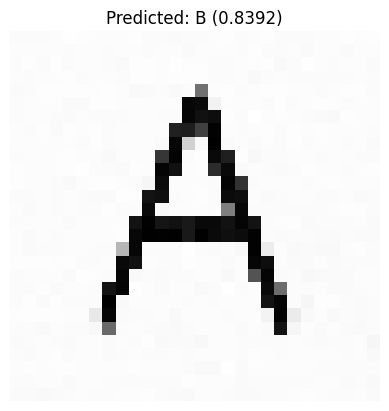

Model: preschool_handwriting_cnn_t4gpu_final (1) (3).keras
No true labels provided, cannot compute accuracy.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab import files
import matplotlib.pyplot as plt
import os

# Define the default model file path
model_path = '/content/preschool_handwriting_cnn_t4gpu_final (1).keras'  # ~85.99% accuracy

# Upload model file (optional, if you want to use a different model)
print("Upload a .keras model file (press Cancel to use default: preschool_handwriting_cnn_t4gpu_final (1).keras):")
uploaded_models = files.upload()
model_files = [f for f in uploaded_models.keys() if f.endswith('.keras')]

if model_files:
    model_path = model_files[0]
    print(f"Using uploaded model: {model_path}")
else:
    print(f"No valid .keras model uploaded. Using default model: {model_path}")

# Load the model
try:
    if not os.path.exists(model_path):
        print(f"Default model not found at {model_path}. Please upload a valid .keras model file.")
        uploaded_models = files.upload()
        model_files = [f for f in uploaded_models.keys() if f.endswith('.keras')]
        if not model_files:
            raise FileNotFoundError("No valid .keras model uploaded. Exiting.")
        model_path = model_files[0]
    model = load_model(model_path)
    print(f"Loaded model from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Upload preschool handwriting images
print("Upload preschool handwriting images (grayscale, e.g., PNG/JPG):")
uploaded_images = files.upload()
image_files = list(uploaded_images.keys())

if not image_files:
    print("No images uploaded. Please upload at least one image.")
else:
    print("Uploaded image files:", image_files)

# Define class mapping for EMNIST 'byclass'
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

# Optional: Define true labels for uploaded images
label_dict = {
    'q.png': class_mapping.index('q'),  # q is class 52
    # Add more: e.g., 'b.png': class_mapping.index('B'), 'architecture.png': class_mapping.index('a')
}

# Process each uploaded image
correct_predictions = 0
total_predictions = 0

for image_file in image_files:
    # Load and preprocess image
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to load image: {image_file}. Ensure it's a valid image (PNG/JPG).")
        continue

    image = cv2.resize(image, (28, 28))
    image = image.astype('float32') / 255.0
    image = image.reshape(1, 28, 28, 1)

    # Predict
    prediction = model.predict(image, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_char = class_mapping[predicted_class]
    confidence = np.max(prediction)

    # Check if true label is provided
    true_label = label_dict.get(image_file, None)
    if true_label is not None:
        total_predictions += 1
        if predicted_class == true_label:
            correct_predictions += 1
        print(f"Image: {image_file}")
        print(f"True character: {class_mapping[true_label]}")
        print(f"Predicted character: {predicted_char} (Confidence: {confidence:.4f})")
        print(f"Correct: {predicted_class == true_label}\n")
    else:
        print(f"Image: {image_file}")
        print(f"Predicted character: {predicted_char} (Confidence: {confidence:.4f})")
        print("No true label provided.\n")

    # Display the image
    plt.imshow(image[0, :, :, 0], cmap='gray')
    plt.title(f"Predicted: {predicted_char} ({confidence:.4f})")
    plt.axis('off')
    plt.show()

# Calculate and print accuracy (if true labels provided)
if total_predictions > 0:
    accuracy = correct_predictions / total_predictions
    print(f"Model: {model_path}")
    print(f"Accuracy on uploaded images: {accuracy:.4f} ({correct_predictions}/{total_predictions} correct)")
else:
    print(f"Model: {model_path}")
    print("No true labels provided, cannot compute accuracy.")

# Save prediction results to a file
with open('/content/prediction_results.txt', 'w') as f:
    for image_file in image_files:
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, (28, 28))
            image = image.astype('float32') / 255.0
            image = image.reshape(1, 28, 28, 1)
            prediction = model.predict(image, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]
            predicted_char = class_mapping[predicted_class]
            confidence = np.max(prediction)
            f.write(f"Image: {image_file}, Predicted: {predicted_char}, Confidence: {confidence:.4f}\n")
    f.write(f"Model: {model_path}, Accuracy: {accuracy:.4f} ({correct_predictions}/{total_predictions} correct)" if total_predictions > 0 else f"Model: {model_path}, No accuracy computed")

# Download the prediction results
files.download('/content/prediction_results.txt')

Upload a .keras model file (press Cancel to use default: preschool_handwriting_cnn_t4gpu_final (1).keras):


Saving preschool_handwriting_cnn_t4gpu_final (1).keras to preschool_handwriting_cnn_t4gpu_final (1) (4).keras
Using uploaded model: preschool_handwriting_cnn_t4gpu_final (1) (4).keras
Loaded model from preschool_handwriting_cnn_t4gpu_final (1) (4).keras
Upload preschool handwriting images (grayscale, e.g., PNG/JPG):


Saving q.png to q (1).png
Uploaded image files: ['q (1).png']
Image: q (1).png
Predicted character: Q (Confidence: 0.9384)
No true label provided.



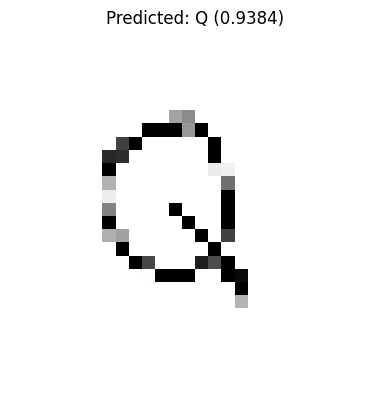

Model: preschool_handwriting_cnn_t4gpu_final (1) (4).keras
No true labels provided, cannot compute accuracy.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab import files
import matplotlib.pyplot as plt
import os

# Define the default model file path
model_path = '/content/preschool_handwriting_cnn_t4gpu_final (1).keras'  # ~85.99% accuracy

# Upload model file (optional, if you want to use a different model)
print("Upload a .keras model file (press Cancel to use default: preschool_handwriting_cnn_t4gpu_final (1).keras):")
uploaded_models = files.upload()
model_files = [f for f in uploaded_models.keys() if f.endswith('.keras')]

if model_files:
    model_path = model_files[0]
    print(f"Using uploaded model: {model_path}")
else:
    print(f"No valid .keras model uploaded. Using default model: {model_path}")

# Load the model
try:
    if not os.path.exists(model_path):
        print(f"Default model not found at {model_path}. Please upload a valid .keras model file.")
        uploaded_models = files.upload()
        model_files = [f for f in uploaded_models.keys() if f.endswith('.keras')]
        if not model_files:
            raise FileNotFoundError("No valid .keras model uploaded. Exiting.")
        model_path = model_files[0]
    model = load_model(model_path)
    print(f"Loaded model from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Upload preschool handwriting images
print("Upload preschool handwriting images (grayscale, e.g., PNG/JPG):")
uploaded_images = files.upload()
image_files = list(uploaded_images.keys())

if not image_files:
    print("No images uploaded. Please upload at least one image.")
else:
    print("Uploaded image files:", image_files)

# Define class mapping for EMNIST 'byclass'
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

# Optional: Define true labels for uploaded images
label_dict = {
    'q.png': class_mapping.index('q'),  # q is class 52
    # Add more: e.g., 'b.png': class_mapping.index('B'), 'architecture.png': class_mapping.index('a')
}

# Process each uploaded image
correct_predictions = 0
total_predictions = 0

for image_file in image_files:
    # Load and preprocess image
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to load image: {image_file}. Ensure it's a valid image (PNG/JPG).")
        continue

    image = cv2.resize(image, (28, 28))
    image = image.astype('float32') / 255.0
    image = image.reshape(1, 28, 28, 1)

    # Predict
    prediction = model.predict(image, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_char = class_mapping[predicted_class]
    confidence = np.max(prediction)

    # Check if true label is provided
    true_label = label_dict.get(image_file, None)
    if true_label is not None:
        total_predictions += 1
        if predicted_class == true_label:
            correct_predictions += 1
        print(f"Image: {image_file}")
        print(f"True character: {class_mapping[true_label]}")
        print(f"Predicted character: {predicted_char} (Confidence: {confidence:.4f})")
        print(f"Correct: {predicted_class == true_label}\n")
    else:
        print(f"Image: {image_file}")
        print(f"Predicted character: {predicted_char} (Confidence: {confidence:.4f})")
        print("No true label provided.\n")

    # Display the image
    plt.imshow(image[0, :, :, 0], cmap='gray')
    plt.title(f"Predicted: {predicted_char} ({confidence:.4f})")
    plt.axis('off')
    plt.show()

# Calculate and print accuracy (if true labels provided)
if total_predictions > 0:
    accuracy = correct_predictions / total_predictions
    print(f"Model: {model_path}")
    print(f"Accuracy on uploaded images: {accuracy:.4f} ({correct_predictions}/{total_predictions} correct)")
else:
    print(f"Model: {model_path}")
    print("No true labels provided, cannot compute accuracy.")

# Save prediction results to a file
with open('/content/prediction_results.txt', 'w') as f:
    for image_file in image_files:
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, (28, 28))
            image = image.astype('float32') / 255.0
            image = image.reshape(1, 28, 28, 1)
            prediction = model.predict(image, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]
            predicted_char = class_mapping[predicted_class]
            confidence = np.max(prediction)
            f.write(f"Image: {image_file}, Predicted: {predicted_char}, Confidence: {confidence:.4f}\n")
    f.write(f"Model: {model_path}, Accuracy: {accuracy:.4f} ({correct_predictions}/{total_predictions} correct)" if total_predictions > 0 else f"Model: {model_path}, No accuracy computed")

# Download the prediction results
files.download('/content/prediction_results.txt')

Loaded model from /content/preschool_handwriting_cnn_t4gpu_final (1).keras
Augmented batch shape: (8, 28, 28, 1)
Epoch 89/91
 499/8725 ━━━━━━━━━━━━━━━━━━━━ 15:49 115ms/step - accuracy: 0.8255 - loss: 0.4932
Saved model at step 500 to /content/preschool_handwriting_cnn_t4gpu_updated_step_500.keras
 999/8725 ━━━━━━━━━━━━━━━━━━━━ 14:43 114ms/step - accuracy: 0.8256 - loss: 0.5034
Saved model at step 1000 to /content/preschool_handwriting_cnn_t4gpu_updated_step_1000.keras
1499/8725 ━━━━━━━━━━━━━━━━━━━━ 13:43 114ms/step - accuracy: 0.8260 - loss: 0.5045
Saved model at step 1500 to /content/preschool_handwriting_cnn_t4gpu_updated_step_1500.keras
1999/8725 ━━━━━━━━━━━━━━━━━━━━ 12:45 114ms/step - accuracy: 0.8256 - loss: 0.5062
Saved model at step 2000 to /content/preschool_handwriting_cnn_t4gpu_updated_step_2000.keras
2499/8725 ━━━━━━━━━━━━━━━━━━━━ 11:48 114ms/step - accuracy: 0.8255 - loss: 0.5066
Saved model at step 2500 to /content/preschool_handwriting_cnn_t4gpu_updated_step_2500.keras
29

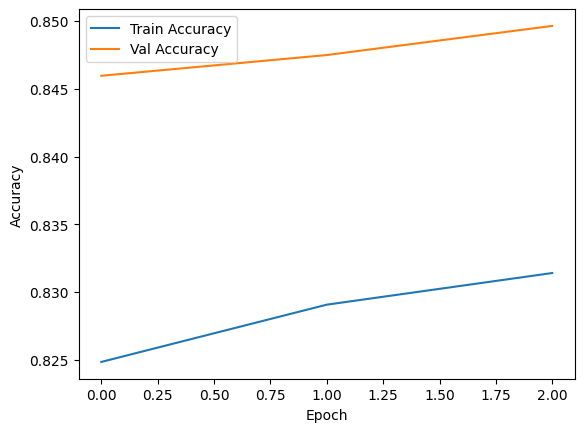

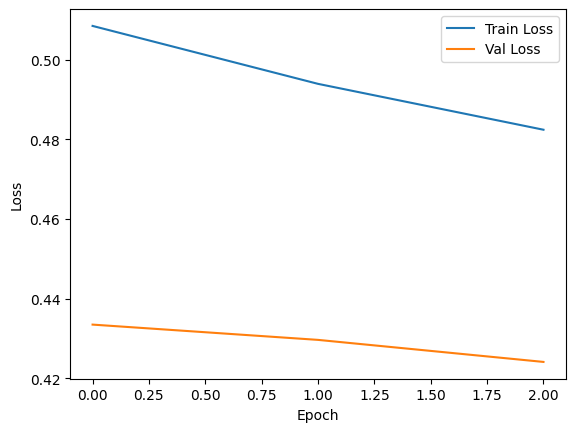

14541/14541 ━━━━━━━━━━━━━━━━━━━━ 307s 21ms/step - accuracy: 0.8494 - loss: 0.4241
Test accuracy: 0.8496
Test loss: 0.4241
Final model saved to /content/preschool_handwriting_cnn_t4gpu_final.keras
-rw-r--r-- 1 root root 66M Sep 30 11:13 /content/preschool_handwriting_cnn_t4gpu_updated.keras
-rw-r--r-- 1 root root 66M Sep 30 10:33 /content/preschool_handwriting_cnn_t4gpu_updated_step_10000.keras
-rw-r--r-- 1 root root 66M Sep 30 10:12 /content/preschool_handwriting_cnn_t4gpu_updated_step_1000.keras
-rw-r--r-- 1 root root 66M Sep 30 10:34 /content/preschool_handwriting_cnn_t4gpu_updated_step_10500.keras
-rw-r--r-- 1 root root 66M Sep 30 10:35 /content/preschool_handwriting_cnn_t4gpu_updated_step_11000.keras
-rw-r--r-- 1 root root 66M Sep 30 10:36 /content/preschool_handwriting_cnn_t4gpu_updated_step_11500.keras
-rw-r--r-- 1 root root 66M Sep 30 10:37 /content/preschool_handwriting_cnn_t4gpu_updated_step_12000.keras
-rw-r--r-- 1 root root 66M Sep 30 10:38 /content/preschool_handwriting_cnn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from google.colab import files
import os

# Enable mixed precision for faster training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Load dataset (10% for better accuracy)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train[:10%]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

# Batch sizes and steps
BATCH_SIZE = 8
TRAIN_SAMPLES = 69793  # 10% of 697,932
TEST_SAMPLES = 116323
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE + 1  # ~8725
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~14541

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Custom checkpoint callback
class StepCheckpoint(callbacks.Callback):
    def __init__(self, save_path, save_freq=500):
        super(StepCheckpoint, self).__init__()
        self.save_path = save_path
        self.save_freq = save_freq
        self.step_count = 0

    def on_batch_end(self, batch, logs=None):
        self.step_count += 1
        if self.step_count % self.save_freq == 0:
            self.model.save(self.save_path.replace('.keras', f'_step_{self.step_count}.keras'))
            print(f"\nSaved model at step {self.step_count} to {self.save_path.replace('.keras', f'_step_{self.step_count}.keras')}")

# Define model path
model_path = '/content/preschool_handwriting_cnn_t4gpu_final (1).keras'  # ~85.99% accuracy

# Upload model if default is missing
if not os.path.exists(model_path):
    print(f"Model not found at {model_path}. Please upload a valid .keras model file.")
    uploaded = files.upload()
    model_files = [f for f in uploaded.keys() if f.endswith('.keras')]
    if not model_files:
        raise FileNotFoundError("No valid .keras model uploaded. Exiting.")
    model_path = model_files[0]

# Load the model
try:
    model = load_model(model_path)
    print(f"Loaded model from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

initial_epoch = 88  # Resume from epoch 89

# Compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define moderate augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.05)
])

# Apply augmentation
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
for image, label in ds_train_aug.take(1):
    print("Augmented batch shape:", image.shape)  # (8, 28, 28, 1)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    return float(lr * tf.math.exp(-0.01))
lr_scheduler = callbacks.LearningRateScheduler(scheduler)
checkpoint = callbacks.ModelCheckpoint(
    '/content/preschool_handwriting_cnn_t4gpu_updated.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
step_checkpoint = StepCheckpoint(
    save_path='/content/preschool_handwriting_cnn_t4gpu_updated.keras',
    save_freq=500
)

# Train for 2-3 epochs
try:
    history = model.fit(
        ds_train_aug,
        epochs=91,  # 2-3 more epochs
        initial_epoch=initial_epoch,
        validation_data=ds_test,
        callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint, step_checkpoint],
        steps_per_epoch=STEPS_PER_EPOCH,  # ~8725
        validation_steps=VALIDATION_STEPS,  # ~14541
        verbose=1
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
except NameError:
    print("Error: ds_test, STEPS_PER_EPOCH, or VALIDATION_STEPS not defined.")
    raise

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=1)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Save the final model
final_model_path = '/content/preschool_handwriting_cnn_t4gpu_final.keras'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

# Verify saved files
!ls -lh /content/preschool_handwriting_cnn_t4gpu_updated*.keras
!ls -lh {final_model_path}

# Download the final model
files.download(final_model_path)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from google.colab import files
import os

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Load dataset (10% for training)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train[:10%]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

# Batch sizes and steps
BATCH_SIZE = 8
TRAIN_SAMPLES = 69793  # 10% of 697,932
TEST_SAMPLES = 116323
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE + 1  # ~8725
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~14541

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Custom checkpoint callback
class StepCheckpoint(callbacks.Callback):
    def __init__(self, save_path, save_freq=500):
        super(StepCheckpoint, self).__init__()
        self.save_path = save_path
        self.save_freq = save_freq
        self.step_count = 0

    def on_batch_end(self, batch, logs=None):
        self.step_count += 1
        if self.step_count % self.save_freq == 0:
            self.model.save(self.save_path.replace('.keras', f'_step_{self.step_count}.keras'))
            print(f"\nSaved model at step {self.step_count} to {self.save_path.replace('.keras', f'_step_{self.step_count}.keras')}")

# Define model path
model_path = '/content/preschool_handwriting_cnn_t4gpu_final (1).keras'  # ~85.99% accuracy

# Upload model if missing
if not os.path.exists(model_path):
    print(f"Model not found at {model_path}. Please upload a valid .keras model file.")
    uploaded = files.upload()
    model_files = [f for f in uploaded.keys() if f.endswith('.keras')]
    if not model_files:
        raise FileNotFoundError("No valid .keras model uploaded. Exiting.")
    model_path = model_files[0]

# Load the model
try:
    model = load_model(model_path)
    print(f"Loaded model from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Add L2 regularization to dense layers
for layer in model.layers:
    if isinstance(layer, layers.Dense):
        layer.kernel_regularizer = regularizers.l2(0.01)

# Compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define stronger augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.1),  # Increased from 0.05
    layers.RandomTranslation(0.1, 0.1),  # Increased from 0.05
    layers.RandomZoom(0.1),  # Increased from 0.05
    layers.RandomContrast(0.1)  # New: slight contrast adjustment
])

# Apply augmentation
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
for image, label in ds_train_aug.take(1):
    print("Augmented batch shape:", image.shape)  # (8, 28, 28, 1)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    return float(lr * tf.math.exp(-0.02))
lr_scheduler = callbacks.LearningRateScheduler(scheduler)
checkpoint = callbacks.ModelCheckpoint(
    '/content/preschool_handwriting_cnn_t4gpu_updated.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
step_checkpoint = StepCheckpoint(
    save_path='/content/preschool_handwriting_cnn_t4gpu_updated.keras',
    save_freq=500
)

# Train for 3-5 epochs
try:
    history = model.fit(
        ds_train_aug,
        epochs=93,  # 5 more epochs from 88
        initial_epoch=88,
        validation_data=ds_test,
        callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint, step_checkpoint],
        steps_per_epoch=STEPS_PER_EPOCH,  # ~8725
        validation_steps=VALIDATION_STEPS,  # ~14541
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
except NameError:
    print("Error: ds_test, STEPS_PER_EPOCH, or VALIDATION_STEPS not defined.")
    raise

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=1)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Save the final model
final_model_path = '/content/preschool_handwriting_cnn_t4gpu_final.keras'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

# Verify saved files
!ls -lh /content/preschool_handwriting_cnn_t4gpu_updated*.keras
!ls -lh {final_model_path}

# Download the final model
files.download(final_model_path)

Loaded model from /content/preschool_handwriting_cnn_t4gpu_final (1).keras
Augmented batch shape: (8, 28, 28, 1)
Epoch 89/93
 499/8725 ━━━━━━━━━━━━━━━━━━━━ 14:55 109ms/step - accuracy: 0.8062 - loss: 0.5540
Saved model at step 500 to /content/preschool_handwriting_cnn_t4gpu_updated_step_500.keras
 999/8725 ━━━━━━━━━━━━━━━━━━━━ 14:06 110ms/step - accuracy: 0.8064 - loss: 0.5580
Saved model at step 1000 to /content/preschool_handwriting_cnn_t4gpu_updated_step_1000.keras
1499/8725 ━━━━━━━━━━━━━━━━━━━━ 13:14 110ms/step - accuracy: 0.8069 - loss: 0.5601
Saved model at step 1500 to /content/preschool_handwriting_cnn_t4gpu_updated_step_1500.keras
1999/8725 ━━━━━━━━━━━━━━━━━━━━ 12:18 110ms/step - accuracy: 0.8076 - loss: 0.5601
Saved model at step 2000 to /content/preschool_handwriting_cnn_t4gpu_updated_step_2000.keras
2499/8725 ━━━━━━━━━━━━━━━━━━━━ 11:23 110ms/step - accuracy: 0.8082 - loss: 0.5601
Saved model at step 2500 to /content/preschool_handwriting_cnn_t4gpu_updated_step_2500.keras
29

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import files
import os

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Define ResNet-18 architecture
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

def build_resnet18(input_shape=(28, 28, 1), num_classes=62):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Residual blocks
    x = residual_block(x, 64, stride=1, conv_shortcut=False)
    x = residual_block(x, 64, stride=1, conv_shortcut=False)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1, conv_shortcut=False)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1, conv_shortcut=False)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1, conv_shortcut=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    return models.Model(inputs, outputs)

# Load full EMNIST dataset
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

# Batch sizes and steps
BATCH_SIZE = 16  # CPU-friendly
TRAIN_SAMPLES = 697932
TEST_SAMPLES = 116323
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE + 1  # ~43621
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~7271

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Custom checkpoint callback
class StepCheckpoint(callbacks.Callback):
    def __init__(self, save_path, save_freq=1000):
        super(StepCheckpoint, self).__init__()
        self.save_path = save_path
        self.save_freq = save_freq
        self.step_count = 0

    def on_batch_end(self, batch, logs=None):
        self.step_count += 1
        if self.step_count % self.save_freq == 0:
            self.model.save(self.save_path.replace('.keras', f'_step_{self.step_count}.keras'))
            print(f"\nSaved model at step {self.step_count} to {self.save_path.replace('.keras', f'_step_{self.step_count}.keras')}")

# Build ResNet-18 model
model = build_resnet18()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Higher for new model
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define strong augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15)
])

# Apply augmentation
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
for image, label in ds_train_aug.take(1):
    print("Augmented batch shape:", image.shape)  # (16, 28, 28, 1)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    mode='max'
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    mode='max'
)
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    return float(lr * tf.math.exp(-0.01))
lr_scheduler = callbacks.LearningRateScheduler(scheduler)
checkpoint = callbacks.ModelCheckpoint(
    '/content/preschool_handwriting_resnet18_updated.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
step_checkpoint = StepCheckpoint(
    save_path='/content/preschool_handwriting_resnet18_updated.keras',
    save_freq=1000
)

# Train for 10 epochs
try:
    history = model.fit(
        ds_train_aug,
        epochs=10,
        initial_epoch=0,
        validation_data=ds_test,
        callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint, step_checkpoint],
        steps_per_epoch=STEPS_PER_EPOCH,  # ~43621
        validation_steps=VALIDATION_STEPS,  # ~7271
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
except NameError:
    print("Error: ds_test, STEPS_PER_EPOCH, or VALIDATION_STEPS not defined.")
    raise

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=1)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Save the final model
final_model_path = '/content/preschool_handwriting_resnet18_final.keras'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

# Verify saved files
!ls -lh /content/preschool_handwriting_resnet18_updated*.keras
!ls -lh {final_model_path}

# Download the final model
files.download(final_model_path)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.MQSNSZ_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.MQSNSZ_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
Augmented batch shape: (16, 28, 28, 1)
Epoch 1/10
  999/43621 ━━━━━━━━━━━━━━━━━━━━ 10:59 15ms/step - accuracy: 0.2669 - loss: 7.1311
Saved model at step 1000 to /content/preschool_handwriting_resnet18_updated_step_1000.keras
 1999/43621 ━━━━━━━━━━━━━━━━━━━━ 11:30 17ms/step - accuracy: 0.3676 - loss: 6.5367
Saved model at step 2000 to /content/preschool_handwriting_resnet18_updated_step_2000.keras
 2998/43621 ━━━━━━━━━━━━━━━━━━━━ 11:17 17ms/step - accuracy: 0.4271 - loss: 6.1726
Saved model at step 3000 to /content/preschool_handwriting_resnet18_updated_step_3000.keras
 3999/43621 ━━━━━━━━━━━━━━━━━━━━ 11:01 17ms/step - accuracy: 0.4679 - loss: 5.9037
Saved model at step 4000 to /content/preschool_handwriting_resnet18_updated_step_4000.keras
 4996/43621 ━━━━━━━━━━━━━━━━━━━━ 10:48 17ms/step - accuracy: 0.4979 - loss: 5.6869
Saved model at step 5000 to /content/p

Loaded model from /content/preschool_handwriting_cnn_t4gpu_final (1).keras
Augmented batch shape: (8, 28, 28, 1)
Epoch 89/91
 499/8725 ━━━━━━━━━━━━━━━━━━━━ 15:49 115ms/step - accuracy: 0.8255 - loss: 0.4932
Saved model at step 500 to /content/preschool_handwriting_cnn_t4gpu_updated_step_500.keras
 999/8725 ━━━━━━━━━━━━━━━━━━━━ 14:43 114ms/step - accuracy: 0.8256 - loss: 0.5034
Saved model at step 1000 to /content/preschool_handwriting_cnn_t4gpu_updated_step_1000.keras
1499/8725 ━━━━━━━━━━━━━━━━━━━━ 13:43 114ms/step - accuracy: 0.8260 - loss: 0.5045
Saved model at step 1500 to /content/preschool_handwriting_cnn_t4gpu_updated_step_1500.keras
1999/8725 ━━━━━━━━━━━━━━━━━━━━ 12:45 114ms/step - accuracy: 0.8256 - loss: 0.5062
Saved model at step 2000 to /content/preschool_handwriting_cnn_t4gpu_updated_step_2000.keras
2499/8725 ━━━━━━━━━━━━━━━━━━━━ 11:48 114ms/step - accuracy: 0.8255 - loss: 0.5066
Saved model at step 2500 to /content/preschool_handwriting_cnn_t4gpu_updated_step_2500.keras
29

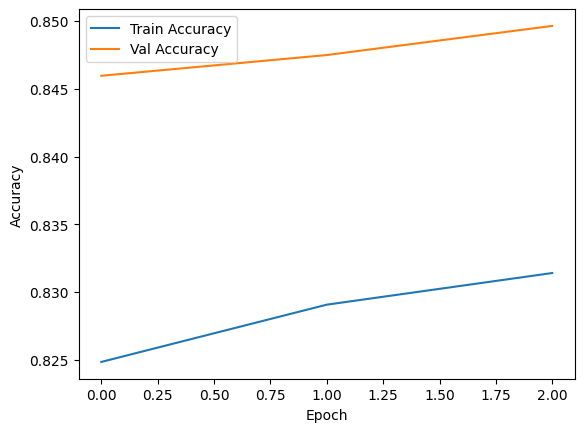

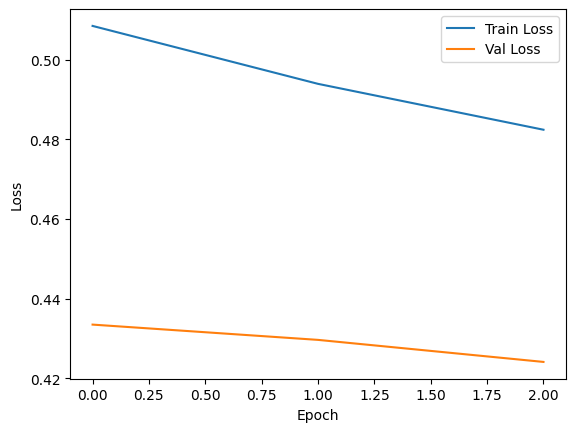

14541/14541 ━━━━━━━━━━━━━━━━━━━━ 307s 21ms/step - accuracy: 0.8494 - loss: 0.4241
Test accuracy: 0.8496
Test loss: 0.4241
Final model saved to /content/preschool_handwriting_cnn_t4gpu_final.keras
-rw-r--r-- 1 root root 66M Sep 30 11:13 /content/preschool_handwriting_cnn_t4gpu_updated.keras
-rw-r--r-- 1 root root 66M Sep 30 10:33 /content/preschool_handwriting_cnn_t4gpu_updated_step_10000.keras
-rw-r--r-- 1 root root 66M Sep 30 10:12 /content/preschool_handwriting_cnn_t4gpu_updated_step_1000.keras
-rw-r--r-- 1 root root 66M Sep 30 10:34 /content/preschool_handwriting_cnn_t4gpu_updated_step_10500.keras
-rw-r--r-- 1 root root 66M Sep 30 10:35 /content/preschool_handwriting_cnn_t4gpu_updated_step_11000.keras
-rw-r--r-- 1 root root 66M Sep 30 10:36 /content/preschool_handwriting_cnn_t4gpu_updated_step_11500.keras
-rw-r--r-- 1 root root 66M Sep 30 10:37 /content/preschool_handwriting_cnn_t4gpu_updated_step_12000.keras
-rw-r--r-- 1 root root 66M Sep 30 10:38 /content/preschool_handwriting_cnn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from google.colab import files
import os

# Enable mixed precision for faster training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Load dataset (10% for better accuracy)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train[:10%]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

# Batch sizes and steps
BATCH_SIZE = 8
TRAIN_SAMPLES = 69793  # 10% of 697,932
TEST_SAMPLES = 116323
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE + 1  # ~8725
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~14541

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Custom checkpoint callback
class StepCheckpoint(callbacks.Callback):
    def __init__(self, save_path, save_freq=500):
        super(StepCheckpoint, self).__init__()
        self.save_path = save_path
        self.save_freq = save_freq
        self.step_count = 0

    def on_batch_end(self, batch, logs=None):
        self.step_count += 1
        if self.step_count % self.save_freq == 0:
            self.model.save(self.save_path.replace('.keras', f'_step_{self.step_count}.keras'))
            print(f"\nSaved model at step {self.step_count} to {self.save_path.replace('.keras', f'_step_{self.step_count}.keras')}")

# Define model path
model_path = '/content/preschool_handwriting_cnn_t4gpu_final (1).keras'  # ~85.99% accuracy

# Upload model if default is missing
if not os.path.exists(model_path):
    print(f"Model not found at {model_path}. Please upload a valid .keras model file.")
    uploaded = files.upload()
    model_files = [f for f in uploaded.keys() if f.endswith('.keras')]
    if not model_files:
        raise FileNotFoundError("No valid .keras model uploaded. Exiting.")
    model_path = model_files[0]

# Load the model
try:
    model = load_model(model_path)
    print(f"Loaded model from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

initial_epoch = 88  # Resume from epoch 89

# Compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define moderate augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.05)
])

# Apply augmentation
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
for image, label in ds_train_aug.take(1):
    print("Augmented batch shape:", image.shape)  # (8, 28, 28, 1)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    return float(lr * tf.math.exp(-0.01))
lr_scheduler = callbacks.LearningRateScheduler(scheduler)
checkpoint = callbacks.ModelCheckpoint(
    '/content/preschool_handwriting_cnn_t4gpu_updated.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
step_checkpoint = StepCheckpoint(
    save_path='/content/preschool_handwriting_cnn_t4gpu_updated.keras',
    save_freq=500
)

# Train for 2-3 epochs
try:
    history = model.fit(
        ds_train_aug,
        epochs=91,  # 2-3 more epochs
        initial_epoch=initial_epoch,
        validation_data=ds_test,
        callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint, step_checkpoint],
        steps_per_epoch=STEPS_PER_EPOCH,  # ~8725
        validation_steps=VALIDATION_STEPS,  # ~14541
        verbose=1
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
except NameError:
    print("Error: ds_test, STEPS_PER_EPOCH, or VALIDATION_STEPS not defined.")
    raise

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=1)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Save the final model
final_model_path = '/content/preschool_handwriting_cnn_t4gpu_final.keras'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

# Verify saved files
!ls -lh /content/preschool_handwriting_cnn_t4gpu_updated*.keras
!ls -lh {final_model_path}

# Download the final model
files.download(final_model_path)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import files, drive
import os

# Mount Google Drive
try:
    drive.mount('/content/drive')
    drive_path = '/content/drive/My Drive/preschool_handwriting_models'
    os.makedirs(drive_path, exist_ok=True)
except Exception as e:
    print(f"Failed to mount Google Drive: {e}")
    drive_path = None

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Clear session to free memory
tf.keras.backend.clear_session()

# Define ResNet-18 architecture (for fallback)
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

def build_resnet18(input_shape=(28, 28, 1), num_classes=62):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.0005))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = residual_block(x, 64, stride=1, conv_shortcut=False)
    x = residual_block(x, 64, stride=1, conv_shortcut=False)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1, conv_shortcut=False)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1, conv_shortcut=False)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1, conv_shortcut=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    return models.Model(inputs, outputs)

# Load EMNIST dataset
try:
    (ds_train, ds_test), ds_info = tfds.load(
        'emnist/byclass',
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True
    )
except Exception as e:
    print(f"Failed to load EMNIST dataset: {e}")
    raise

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

# Batch sizes and steps
BATCH_SIZE = 8
TRAIN_SAMPLES = 697932
TEST_SAMPLES = 116323
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE + 1  # ~87241
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~14541

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Custom checkpoint callback
class StepCheckpoint(callbacks.Callback):
    def __init__(self, save_path, drive_path, save_freq=1000):
        super(StepCheckpoint, self).__init__()
        self.save_path = save_path
        self.drive_path = drive_path
        self.save_freq = save_freq
        self.step_count = 0

    def on_batch_end(self, batch, logs=None):
        self.step_count += 1
        if self.step_count % self.save_freq == 0:
            checkpoint_file = self.save_path.replace('.keras', f'_step_{self.step_count}.keras')
            self.model.save(checkpoint_file)
            print(f"\nSaved model at step {self.step_count} to {checkpoint_file}")
            if self.drive_path:
                drive_file = os.path.join(self.drive_path, os.path.basename(checkpoint_file))
                self.model.save(drive_file)
                print(f"Saved model to {drive_file}")
            try:
                files.download(checkpoint_file)
                print(f"Downloaded {checkpoint_file}")
            except Exception as e:
                print(f"Failed to download {checkpoint_file}: {e}")

# Check available checkpoints
print("Checking available checkpoints:")
!ls -lh /content/preschool_handwriting_resnet18_updated*.keras
if drive_path:
    !ls -lh "{drive_path}"

# Load latest checkpoint
checkpoint_path = '/content/preschool_handwriting_resnet18_updated_step_191000.keras'
model = None
if os.path.exists(checkpoint_path):
    try:
        model = tf.keras.models.load_model(checkpoint_path)
        print(f"Loaded checkpoint from {checkpoint_path}")
        initial_epoch = 5
        initial_step = 191000
    except Exception as e:
        print(f"Failed to load {checkpoint_path}: {e}")
        checkpoint_path = None

if not model:
    checkpoint_files = [f for f in os.listdir('/content') if f.startswith('preschool_handwriting_resnet18_updated_step_') and f.endswith('.keras')]
    if checkpoint_files:
        latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_step_')[1].split('.keras')[0]))
        checkpoint_path = f'/content/{latest_checkpoint}'
        try:
            model = tf.keras.models.load_model(checkpoint_path)
            print(f"Loaded latest checkpoint from {checkpoint_path}")
            initial_epoch = 5
            initial_step = int(latest_checkpoint.split('_step_')[1].split('.keras')[0])
        except Exception as e:
            print(f"Failed to load {checkpoint_path}: {e}")
            checkpoint_path = None

if not model and drive_path:
    print(f"No checkpoints found in /content. Checking Google Drive...")
    drive_checkpoint_files = [f for f in os.listdir(drive_path) if f.startswith('preschool_handwriting_resnet18_updated_step_') and f.endswith('.keras')]
    if drive_checkpoint_files:
        latest_checkpoint = max(drive_checkpoint_files, key=lambda x: int(x.split('_step_')[1].split('.keras')[0]))
        checkpoint_path = os.path.join(drive_path, latest_checkpoint)
        try:
            model = tf.keras.models.load_model(checkpoint_path)
            print(f"Loaded latest checkpoint from {checkpoint_path}")
            initial_epoch = 5
            initial_step = int(latest_checkpoint.split('_step_')[1].split('.keras')[0])
        except Exception as e:
            print(f"Failed to load {checkpoint_path}: {e}")
            checkpoint_path = None

# Fallback: Start fresh if no valid checkpoint
if not model:
    print("No valid checkpoints found. Starting fresh with ResNet-18.")
    model = build_resnet18()
    initial_epoch = 0
    initial_step = 0

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005 if initial_epoch > 0 else 0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Test checkpoint on a small batch
try:
    test_loss, test_acc = model.evaluate(ds_test.take(100), verbose=1)
    print(f'Checkpoint Test accuracy (100 batches): {test_acc:.4f}')
except Exception as e:
    print(f"Checkpoint evaluation failed: {e}")
    print("Starting fresh with ResNet-18.")
    model = build_resnet18()
    initial_epoch = 0
    initial_step = 0
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

# Define minimal augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.03),
    layers.RandomTranslation(0.03, 0.03),
    layers.RandomZoom(0.03)
])

# Apply augmentation
def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
for image, label in ds_train_aug.take(1):
    print("Augmented batch shape:", image.shape)  # (8, 28, 28, 1)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    mode='max'
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    mode='max'
)
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    return float(lr * tf.math.exp(-0.01))
lr_scheduler = callbacks.LearningRateScheduler(scheduler)
checkpoint = callbacks.ModelCheckpoint(
    '/content/preschool_handwriting_resnet18_updated.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
step_checkpoint = StepCheckpoint(
    save_path='/content/preschool_handwriting_resnet18_updated.keras',
    drive_path=drive_path,
    save_freq=1000
)

# Train for 20 epochs to aim for higher accuracy
try:
    history = model.fit(
        ds_train_aug,
        epochs=20,
        initial_epoch=initial_epoch,
        validation_data=ds_test,
        callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint, step_checkpoint],
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
except Exception as e:
    print(f"Training failed: {e}")
    raise

# Evaluate on test set
try:
    test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=1)
    print(f'ResNet-18 Test accuracy: {test_acc:.4f}')
    print(f'ResNet-18 Test loss: {test_loss:.4f}')
except Exception as e:
    print(f"Evaluation failed: {e}")
    raise

# Save the final model
final_model_path = '/content/preschool_handwriting_resnet18_final.keras'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")
if drive_path:
    drive_final_path = os.path.join(drive_path, 'preschool_handwriting_resnet18_final.keras')
    model.save(drive_final_path)
    print(f"Final model saved to {drive_final_path}")

# Verify saved files
!ls -lh /content/preschool_handwriting_resnet18_updated*.keras
!ls -lh {final_model_path}
if drive_path:
    !ls -lh "{drive_path}"

# Download the final model and latest checkpoint
try:
    files.download(final_model_path)
    print(f"Downloaded {final_model_path}")
except Exception as e:
    print(f"Failed to download {final_model_path}: {e}")
latest_checkpoint = max([f for f in os.listdir('/content') if f.startswith('preschool_handwriting_resnet18_updated_step_') and f.endswith('.keras')],
                       key=lambda x: int(x.split('_step_')[1].split('.keras')[0]), default=None)
if latest_checkpoint:
    try:
        files.download(f'/content/{latest_checkpoint}')
        print(f"Downloaded {latest_checkpoint}")
    except Exception as e:
        print(f"Failed to download {latest_checkpoint}: {e}")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import files
import os

In [ ]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train[:5%]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

BATCH_SIZE = 8
TRAIN_SAMPLES = 34897
TEST_SAMPLES = 116323
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE + 1  # ~4363
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~14541

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.5HLA82_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.5HLA82_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.


In [ ]:
NUM_CLASSES = 62
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
augmentation = models.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05)
])

def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    mode='max'
)

checkpoint = callbacks.ModelCheckpoint(
    '/content/preschool_handwriting_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model.fit(
    ds_train_aug,
    epochs=5,  # Fewer epochs for easy run (increase to 10-15 for better accuracy)
    validation_data=ds_test,
    callbacks=[early_stopping, checkpoint],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    verbose=1
)

Epoch 1/5
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.3900 - loss: 2.6734
Epoch 1: val_accuracy improved from -inf to 0.76683, saving model to /content/preschool_handwriting_model.keras
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 2171s 496ms/step - accuracy: 0.3901 - loss: 2.6733 - val_accuracy: 0.7668 - val_loss: 0.8232
Epoch 2/5
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.6527 - loss: 1.2077
Epoch 2: val_accuracy improved from 0.76683 to 0.79896, saving model to /content/preschool_handwriting_model.keras
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 2163s 496ms/step - accuracy: 0.6527 - loss: 1.2076 - val_accuracy: 0.7990 - val_loss: 0.6781
Epoch 3/5
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7054 - loss: 0.9937
Epoch 3: val_accuracy improved from 0.79896 to 0.81194, saving model to /content/preschool_handwriting_model.keras
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 2173s 498ms/step - accuracy: 0.7054 - loss: 0.9937 - val_accuracy: 0.8119 - val_loss: 0.5866
Epoch 4/5
4363/4363

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import files, drive
import os

# Step 1.1: Mount Google Drive
try:
    drive.mount('/content/drive')
    drive_path = '/content/drive/My Drive/preschool_handwriting_models'
    os.makedirs(drive_path, exist_ok=True)
except Exception as e:
    print(f"Failed to mount Google Drive: {e}")
    drive_path = None

# Step 1.2: Clear session
tf.keras.backend.clear_session()

# Step 1.3: Define ResNet-18 model
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

def build_resnet18(input_shape=(28, 28, 1), num_classes=62):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=1, padding='same')(x)

    x = residual_block(x, 64, conv_shortcut=False)
    x = residual_block(x, 64, conv_shortcut=False)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, conv_shortcut=False)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, conv_shortcut=False)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, conv_shortcut=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, x)
    return model

# Step 1.4: Load EMNIST dataset (full training)
try:
    (ds_train, ds_test), ds_info = tfds.load(
        'emnist/byclass',
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True
    )
except Exception as e:
    print(f"Failed to load EMNIST dataset: {e}")
    raise

# Step 1.5: Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

# Step 1.6: Batch sizes and steps
BATCH_SIZE = 64  # Increased for faster training
TRAIN_SAMPLES = 697932
TEST_SAMPLES = 116323
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE + 1  # ~10890
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~1818

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Step 1.7: Build ResNet-18 model
model = build_resnet18()

# Step 1.8: Compile model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Step 1.9: Test model on small batch
try:
    test_loss, test_acc = model.evaluate(ds_test.take(100), verbose=1)
    print(f'Initial Test accuracy (100 batches): {test_acc:.4f}')
except Exception as e:
    print(f"Initial evaluation failed: {e}")

# Step 1.10: Define minimal augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.03)
])

def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Step 1.11: Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    mode='max'
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    mode='max'
)
checkpoint = callbacks.ModelCheckpoint(
    '/content/preschool_handwriting_resnet18.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

# Step 1.12: Train for epochs 1 to 10
try:
    history = model.fit(
        ds_train_aug,
        epochs=10,
        validation_data=ds_test,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
except Exception as e:
    print(f"Training failed: {e}")
    raise

# Step 1.13: Evaluate on test set
try:
    test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=1)
    print(f'ResNet-18 Test accuracy: {test_acc:.4f}')
    print(f'ResNet-18 Test loss: {test_loss:.4f}')
except Exception as e:
    print(f"Evaluation failed: {e}")
    raise

# Step 1.14: Save the final model
final_model_path = '/content/preschool_handwriting_resnet18_final.keras'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")
if drive_path:
    drive_final_path = os.path.join(drive_path, 'preschool_handwriting_resnet18_final.keras')
    model.save(drive_final_path)
    print(f"Final model saved to {drive_final_path}")

# Step 1.15: Verify saved files
!ls -lh /content/preschool_handwriting_resnet18*.keras
!ls -lh {final_model_path}
if drive_path:
    !ls -lh "{drive_path}"

# Step 1.16: Download the final model
try:
    files.download(final_model_path)
    print(f"Downloaded {final_model_path}")
except Exception as e:
    print(f"Failed to download {final_model_path}: {e}")

Mounted at /content/drive


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.BV3PVQ_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.BV3PVQ_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.0181 - loss: 4.1264
Initial Test accuracy (100 batches): 0.0178
Epoch 1/10
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7667 - loss: 0.8472
Epoch 1: val_accuracy improved from -inf to 0.85502, saving model to /content/preschool_handwriting_resnet18.keras
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 742s 66ms/step - accuracy: 0.7667 - loss: 0.8471 - val_accuracy: 0.8550 - val_loss: 0.3966 - learning_rate: 0.0010
Epoch 2/10
10905/10906 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8607 - loss: 0.3777
Epoch 2: val_accuracy improved from 0.85502 to 0.86574, saving model to /content/preschool_handwriting_resnet18.keras
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 709s 65ms/step - accuracy: 0.8607 - loss: 0.3777 - val_accuracy: 0.8657 - val_loss: 0.3644 - learning_rate: 0.0010
Epoch 3/10
10905/10906 ━━━━━━━━━━━━━━━━━

In [ ]:
!ls -lh /content/preschool_handwriting_resnet18.keras
!ls -lh "/content/drive/My Drive/preschool_handwriting_models"

ls: cannot access '/content/preschool_handwriting_resnet18.keras': No such file or directory
total 0


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import files, drive
import os
from google.colab import output

# Anti-disconnection code
def keep_alive():
    output.eval_js('google.colab.kernel.proxyPort(9000)')

# Step 1.1: Mount Google Drive
try:
    drive.mount('/content/drive')
    drive_path = '/content/drive/My Drive/preschool_handwriting_models'
    os.makedirs(drive_path, exist_ok=True)
except Exception as e:
    print(f"Failed to mount Google Drive: {e}")
    drive_path = None

# Step 1.2: Clear session
tf.keras.backend.clear_session()

# Step 1.3: Define ResNet-18 model
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

def build_resnet18(input_shape=(28, 28, 1), num_classes=62):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=1, padding='same')(x)

    x = residual_block(x, 64, conv_shortcut=False)
    x = residual_block(x, 64, conv_shortcut=False)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, conv_shortcut=False)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, conv_shortcut=False)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, conv_shortcut=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, x)
    return model

# Step 1.4: Load EMNIST dataset (full training)
try:
    (ds_train, ds_test), ds_info = tfds.load(
        'emnist/byclass',
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True
    )
except Exception as e:
    print(f"Failed to load EMNIST dataset: {e}")
    raise

# Step 1.5: Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

# Step 1.6: Batch sizes and steps
BATCH_SIZE = 32  # Reduced to avoid memory issues
TRAIN_SAMPLES = 697932
TEST_SAMPLES = 116323
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE + 1  # ~21798
VALIDATION_STEPS = TEST_SAMPLES // BATCH_SIZE + 1  # ~3636

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Step 1.7: Build ResNet-18 model
model = build_resnet18()

# Step 1.8: Compile model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Step 1.9: Test model on small batch
try:
    test_loss, test_acc = model.evaluate(ds_test.take(100), verbose=1)
    print(f'Initial Test accuracy (100 batches): {test_acc:.4f}')
except Exception as e:
    print(f"Initial evaluation failed: {e}")

# Step 1.10: Define minimal augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.03)
])

def augment(image, label):
    image = tf.ensure_shape(image, [None, 28, 28, 1])
    image = augmentation(image, training=True)
    return image, label

ds_train_aug = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Step 1.11: Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    mode='max'
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    mode='max'
)
checkpoint = callbacks.ModelCheckpoint(
    '/content/preschool_handwriting_resnet18.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
# Additional checkpoint for Google Drive
if drive_path:
    drive_checkpoint = callbacks.ModelCheckpoint(
        os.path.join(drive_path, 'preschool_handwriting_resnet18.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )
    callbacks_list = [early_stopping, reduce_lr, checkpoint, drive_checkpoint]
else:
    callbacks_list = [early_stopping, reduce_lr, checkpoint]

# Step 1.12: Train for epochs 1 to 10
try:
    history = model.fit(
        ds_train_aug,
        epochs=10,
        validation_data=ds_test,
        callbacks=callbacks_list,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
except Exception as e:
    print(f"Training failed: {e}")
    raise

# Step 1.13: Evaluate on test set
try:
    test_loss, test_acc = model.evaluate(ds_test, steps=VALIDATION_STEPS, verbose=1)
    print(f'ResNet-18 Test accuracy: {test_acc:.4f}')
    print(f'ResNet-18 Test loss: {test_loss:.4f}')
except Exception as e:
    print(f"Evaluation failed: {e}")
    raise

# Step 1.14: Save the final model
final_model_path = '/content/preschool_handwriting_resnet18_final.keras'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")
if drive_path:
    drive_final_path = os.path.join(drive_path, 'preschool_handwriting_resnet18_final.keras')
    model.save(drive_final_path)
    print(f"Final model saved to {drive_final_path}")

# Step 1.15: Verify saved files
!ls -lh /content/preschool_handwriting_resnet18*.keras
if drive_path:
    !ls -lh "{drive_path}"

# Step 1.16: Download the final model
try:
    files.download(final_model_path)
    print(f"Downloaded {final_model_path}")
except Exception as e:
    print(f"Failed to download {final_model_path}: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - accuracy: 0.0397 - loss: 4.1239
Initial Test accuracy (100 batches): 0.0447
Epoch 1/10
11677/21811 ━━━━━━━━━━━━━━━━━━━━ 6:29:42 2s/step - accuracy: 0.7450 - loss: 0.9421